In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import timedelta, datetime
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import squarify
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('data_merge.xlsx')
df.head()

,Unnamed: 0,customer_id,address,postcode,state,country,property_valuation,transaction_id,product_id,transaction_date,...,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure
0,0,1,060 Morning Avenue,2016,New South Wales,Australia,10,94,86,2017-12-23,...,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,Yes,11
1,1,1,060 Morning Avenue,2016,New South Wales,Australia,10,3765,38,2017-04-06,...,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,Yes,11
2,2,1,060 Morning Avenue,2016,New South Wales,Australia,10,5157,47,2017-05-11,...,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,Yes,11
3,3,1,060 Morning Avenue,2016,New South Wales,Australia,10,9785,72,2017-01-05,...,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,Yes,11
4,4,1,060 Morning Avenue,2016,New South Wales,Australia,10,13424,2,2017-02-21,...,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,No,Yes,11


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14054 entries, 0 to 14053
Data columns (total 30 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Unnamed: 0                           14054 non-null  int64         
 1   customer_id                          14054 non-null  int64         
 2   address                              14054 non-null  object        
 3   postcode                             14054 non-null  int64         
 4   state                                14054 non-null  object        
 5   country                              14054 non-null  object        
 6   property_valuation                   14054 non-null  int64         
 7   transaction_id                       14054 non-null  int64         
 8   product_id                           14054 non-null  int64         
 9   transaction_date                     14054 non-null  datetime64[ns]
 10  online_ord

In [5]:
# drop unnecessary column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [51]:
# Repalce the abbreviations in state column
df.state.replace({'NSW': 'New South Wales', 'VIC': 'Victoria', 'QLD': 'Queensland'}, inplace=True)
df['state'].value_counts()

New South Wales    7438
Victoria           3506
Queensland         3110
Name: state, dtype: int64

### Customer behavior

In [73]:
# Create new column year of birth
now = datetime.now()
year = now.year
df['YOB'] = df['DOB'].apply(lambda time: time.year)

# create column age
df['age'] = year - df['YOB']

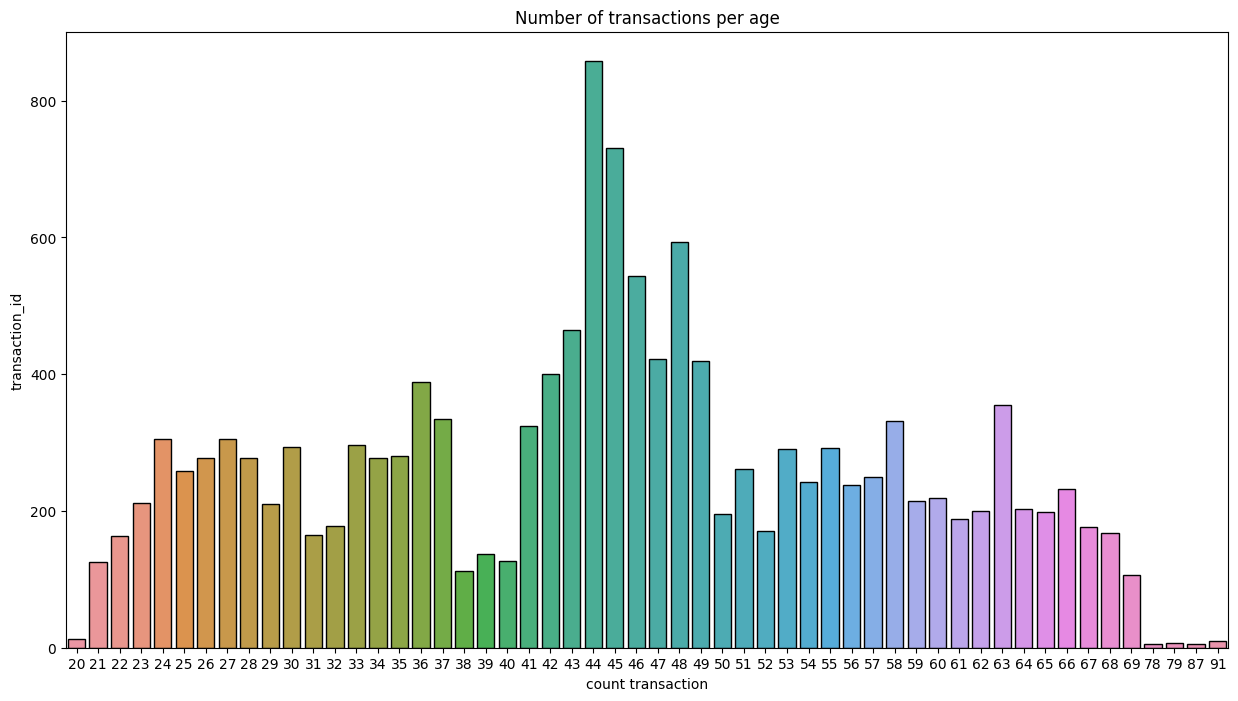

In [75]:
job_title_category = df.groupby('age')['transaction_id'].count().reset_index().sort_values(by='transaction_id', ascending=False)
job_title_category

# create a plot
fig = plt.gcf()
fig.set_size_inches(15, 8)
ax = sns.barplot(data = job_title_category, y = 'transaction_id', x = 'age', linewidth = 1, edgecolor = 'black')
plt.xlabel('count transaction')
ax.set_title('Number of transactions per age')
plt.show()

In [66]:
# Calculate the mean purchase price 
purchase_price_mean = df.list_price.agg('mean')
print('purchase_price_mean:') 
print(purchase_price_mean,'\n')

# Calculate the mean and median purchase price 
purchase_price_summary = df.list_price.agg(['mean', 'median'])
print('purchase_price_summary:')
print(purchase_price_summary)

purchase_price_mean:
1110.6459598690765 

purchase_price_summary:
mean      1110.64596
median    1163.89000
Name: list_price, dtype: float64


In [69]:
# Calculate the mean and median of list price and age
purchase_summary_age = df.agg({'list_price': ['mean','median'], 'age': ['mean','median']})
purchase_summary_age

,list_price,age
mean,1110.64596,44.706205
median,1163.89000,45.000000


Notice how the mean is lower than the median? This suggests that we have some users who are making less of purchases!

In [6]:
grouped_purchase_data = df.groupby(by=['brand', 'gender'])
purchase_summary = grouped_purchase_data.agg({'list_price': ['mean', 'median', 'std']})
purchase_summary

list_price                     
                              mean   median         std
brand          gender                                  
Giant Bicycles Female  1229.227699  1311.44  508.910874
               Male    1245.870145  1311.44  504.166197
Norco Bicycles Female   918.201967   958.74  413.552331
               Male     914.620077   958.74  396.132663
OHM Cycles     Female   983.559752   912.52  660.355134
               Male     993.130093  1073.07  651.467357
Solex          Female  1037.951098  1071.23  606.457483
               Male    1078.717183  1071.23  603.500207
Trek Bicycles  Female  1192.261575  1057.51  652.338001
               Male    1206.539127  1057.51  646.387788
WeareA2B       Female  1249.844208  1292.84  550.178759
               Male    1270.915827  1292.84  541.415855

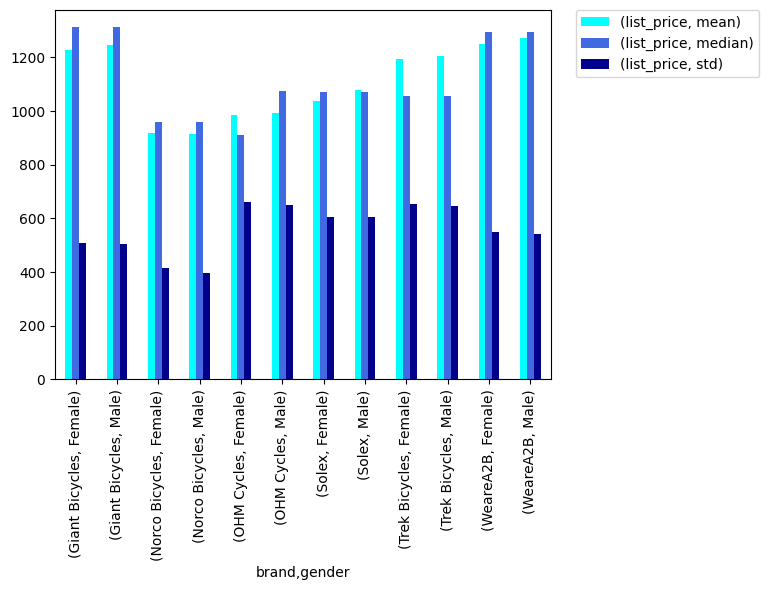

In [55]:
purchase_summary.plot(kind='bar', color=['cyan', 'royalblue', 'darkblue'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [7]:
df.list_price.mean()

1110.6459598690765

The average price is 1110 dollars below $1311.44 it seems that our purchasers tend towards the lower-priced set of options.

### RFM analysis

In [11]:
# Group data by customer_id
# Create TotalSum column for online dataset
df['total_sum'] = df['past_3_years_bike_related_purchases'] * df['standard_cost']

# Create snapshot date
snapshot_date = df['transaction_date'].max() + timedelta(days=1)
print(snapshot_date)

2017-12-31 00:00:00


In [14]:
# Grouping customer_id
df_preprocess = df.groupby('customer_id').agg({
    'transaction_date': lambda x: (snapshot_date - x.max()).days,
    'transaction_id': 'count',
    'total_sum': 'sum'
})

In [15]:
# Rename the columns 
df_preprocess.rename(columns={'transaction_date': 'Recency', 
                        'transaction_id': 'Frequency', 
                        'total_sum': 'Monetary'}, inplace=True)

In [16]:
# Print top 5 rows and shape of dataframe
print(df_preprocess.head())
print('{:,} rows; {:,} columns'.format(df_preprocess.shape[0], df_preprocess.shape[1]))

             Recency  Frequency   Monetary
customer_id                               
1                  8         11  564171.48
2                129          3  155747.61
9                 79          6  291430.68
12                68          7  165542.44
13                28          7  129099.68
2,522 rows; 3 columns


In [32]:
#Calculating R and F groups
# Create labels for Recency and Frequency
r_labels = range(4, 0, -1); f_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups 
r_groups = pd.qcut(df_preprocess['Recency'], q=4, labels=r_labels)
# Assign these labels to 4 equal percentile groups
f_groups = pd.qcut(df_preprocess['Frequency'], q=4, labels=f_labels)
# Create new columns R and F
df_preprocess = df_preprocess.assign(R = r_groups.values, F = f_groups.values)
df_preprocess.head()

,Recency,Frequency,Monetary,R,F
customer_id,,,,,
1,8,11,564171.48,4,4
2,129,3,155747.61,1,1
9,79,6,291430.68,2,3
12,68,7,165542.44,2,3
13,28,7,129099.68,3,3


In [34]:
# Create labels for MonetaryValue
m_labels = range(1, 5)
# Assign these labels to 4 equal percentile groups
m_groups = pd.qcut(df_preprocess['Monetary'], q=4, labels=m_labels)
# Create new column M
df_preprocess = df_preprocess.assign(M = m_groups.values)
df_preprocess.head(10)


,Recency,Frequency,Monetary,R,F,M
customer_id,,,,,,
1,8,11,564171.48,4,4,4
2,129,3,155747.61,1,1,3
9,79,6,291430.68,2,3,4
12,68,7,165542.44,2,3,3
13,28,7,129099.68,3,3,3
14,48,3,67616.65,2,1,2
15,36,6,290740.45,3,3,4
19,281,2,92103.64,1,1,2
20,32,4,216761.76,3,1,4


In [36]:
# Concating the RFM quartile values to create RFM Segments
def join_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])

df_preprocess['RFM_segment'] = df_preprocess.apply(join_rfm, axis=1)
df_rfm = df_preprocess
df_rfm.head()

,Recency,Frequency,Monetary,R,F,M,RFM_segment
customer_id,,,,,,,
1,8,11,564171.48,4,4,4,444
2,129,3,155747.61,1,1,3,113
9,79,6,291430.68,2,3,4,234
12,68,7,165542.44,2,3,3,233
13,28,7,129099.68,3,3,3,333


In [38]:
# Count num of unique segment
df_rfm_unique_count = df_rfm.groupby('RFM_segment')['RFM_segment'].nunique()
print(df_rfm_unique_count.sum())

64


In [40]:
# Calculate RFM_score
df_rfm['RFM_score'] = df_rfm[['R', 'F', 'M']].sum(axis=1)
print(df_rfm['RFM_score'].head())

customer_id
1     12
2      5
9      9
12     8
13     9
Name: RFM_score, dtype: int64


In [42]:
# Define FMCG_rfm_level function
def df_rfm_level(df):
    if df['RFM_score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_score'] >= 8) and (df['RFM_score'] < 9)):
        return 'Champions'
    elif ((df['RFM_score'] >= 7) and (df['RFM_score'] < 8)):
        return 'Loyal/Commited'
    elif ((df['RFM_score'] >= 6) and (df['RFM_score'] < 7)):
        return 'Potential'
    elif ((df['RFM_score'] >= 5) and (df['RFM_score'] < 6)):
        return 'Promising'
    elif ((df['RFM_score'] >= 4) and (df['RFM_score'] < 5)):
        return 'Requires Attention'
    else:
        return 'Demands Activation'

# Create a new variable RFM_level
df_rfm['RFM_Level'] = df_rfm.apply(df_rfm_level, axis=1)
# Print with top 15
df_rfm.head(15)


,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_score,RFM_Level
customer_id,,,,,,,,,
1,8,11,564171.48,4,4,4,12,12,Can't Loose Them
2,129,3,155747.61,1,1,3,5,5,Promising
9,79,6,291430.68,2,3,4,9,9,Can't Loose Them
12,68,7,165542.44,2,3,3,8,8,Champions
13,28,7,129099.68,3,3,3,9,9,Can't Loose Them
14,48,3,67616.65,2,1,2,5,5,Promising
15,36,6,290740.45,3,3,4,10,10,Can't Loose Them
19,281,2,92103.64,1,1,2,4,4,Requires Attention
20,32,4,216761.76,3,1,4,8,8,Champions


In [43]:
# calculate average values for each RFM_level, and return a size of each segment
df_rfm_level_agg = df_rfm.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)
df_rfm_level_agg

Recency Frequency  Monetary      
                      mean      mean      mean count
RFM_Level                                           
Can't Loose Them      29.0       7.6  257965.2   853
Champions             48.1       6.1  151583.2   379
Demands Activation   173.0       2.5   26190.4   171
Loyal/Commited        56.0       5.1  125809.3   355
Potential             62.1       4.5   87521.9   309
Promising             97.2       3.9   86366.2   252
Requires Attention   121.9       3.3   58743.3   203

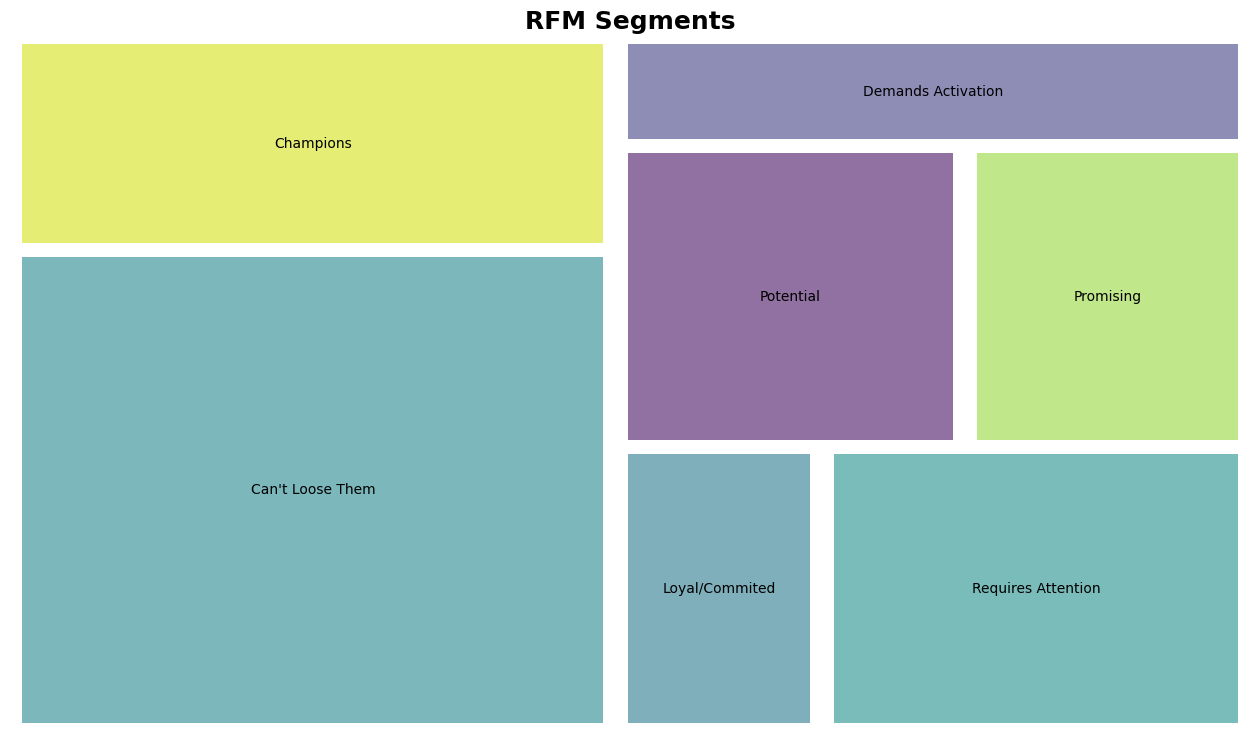

In [47]:
df_rfm_level_agg.columns = ['RecencyMean', 'FrequencyMean', 'MonetaryMean', 'Count']
# Create plot
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=df_rfm_level_agg['Count'], 
            label=['Can\'t Loose Them',
            'Champions','Loyal/Commited',
            'Requires Attention','Potential', 
            'Promising', 
            'Demands Activation'], alpha=.6, pad=2 )

plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()